In [1]:
%pip install -e git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction

Obtaining MI_prediction from git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction
  Updating ./src/mi-prediction clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 47336b21c7afc4ae4ccaca5835bd7e5e6cda8829
  Preparing metadata (setup.py) ... done
  Attempting uninstall: MI_prediction
    Found existing installation: MI-prediction 0.1
    Uninstalling MI-prediction-0.1:
      Successfully uninstalled MI-prediction-0.1
  Running setup.py develop for MI_prediction
Note: you may need to restart the kernel to use updated packages.


In [358]:
from MI_prediction.Utils.Datasets import  DataLoader_Rest, get_epochs, get_runs, get_labels
from MI_prediction.Datasets import Cho2017_Rest, BNCI2014001_Rest
from MI_prediction.Utils.Preprocess import filterbank_preprocessor, filterbank, FBCSP, moments, scaler_list
from MI_prediction.Utils.Windowers import create_windows
from MI_prediction.Utils.Datautils import features_by_channels
from MI_prediction.Models import DLSMR
from braindecode.preprocessing.preprocess import exponential_moving_standardize, preprocess, Preprocessor, scale
from scikeras.wrappers import KerasRegressor 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV,LeaveOneOut,cross_val_predict

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from mne.preprocessing import compute_current_source_density
import tensorflow as tf
from sklearn.metrics import r2_score

from MI_prediction.Utils.Wrappers import MultiInputRegressor, MultiInputScaler

import time
import pickle

# GIGAScience Cho2017

In [2]:
dl = DataLoader_Rest(dataset_name=Cho2017_Rest())

subjects = np.arange(1,53)
subjects = subjects[(subjects!=32) & (subjects!=46) & (subjects!=49)]

duration=66

## Preprocessing

### For moments

In [3]:
fb = filterbank_preprocessor([(8.,15.),(15.,25.)], method='iir',iir_params={'order':5,'ftype':'butter'})

preprocessors_mts = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        Preprocessor('pick_channels', ch_names=['C3', 'C4', 'Cz', 'P3', 'P4', 'Pz']),  # Keep only EEG channels
        Preprocessor(scale, factor=1e3, apply_on_array=True),  # Convert from V to uV
        Preprocessor('filter',l_freq=1., h_freq=None, method='iir',iir_params={'order':5,'ftype':'butter'})
        ]

Ch_prep = [
        Preprocessor(compute_current_source_density,copy=False,apply_on_array=False)
        ]

st_offsets_mts, ed_offsets_mts = create_windows(win = 2, start_offset = 5, end_offset = -6, mi_duration = duration, overlap = 0.5)

band to filter: (8.0, 15.0) Hz
band to filter: (15.0, 25.0) Hz


### For PSD

In [4]:
preprocessors_psd = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        Preprocessor('pick_channels', ch_names=['C3', 'C4', 'Cz', 'P3', 'P4', 'Pz']), 
        Preprocessor(scale, factor=1e3, apply_on_array=True),  # Convert from V to uV
        Preprocessor('filter',l_freq=8., h_freq=30., method='iir',iir_params={'order':5,'ftype':'butter'}),
        Preprocessor(compute_current_source_density,copy=False,apply_on_array=False)
        ]
st_offsets_psd, ed_offsets_psd = create_windows(win = 55, start_offset = 5, end_offset = -6, mi_duration = duration, overlap = 0)

## Feature extraction

In [6]:
Epochs_mts = []
Epochs_psd = []

for s in subjects:
    print ("Subject: {}".format(s))
    tic = time.time()

    dl.load_data(subject_ids=[s])

    ds_f = filterbank(dl, preprocess=preprocessors_mts, filters=fb, channels_prep=Ch_prep)
    trials = [tr.get_trials(start_offset=st_offsets_mts, end_offset=ed_offsets_mts) for tr in ds_f]

    epochs_mts = []
    for nw in trials[0].keys():
        epochs_mts.append(np.concatenate([np.expand_dims(moments(get_epochs(epoch[nw].split('session')['session_0'])),axis=3) for epoch in trials],axis=-1))

    Epochs_mts.append(np.concatenate(epochs_mts, axis=2))

    fs = dl.dataset.datasets[0].raw.info['sfreq']

    dl.preprocess_data(preprocessors=preprocessors_psd)
    trials_psd = dl.get_trials(start_offset=st_offsets_psd, end_offset=ed_offsets_psd)

    Epochs_psd.append(welch(get_epochs(trials_psd['win_0'])[0],fs=fs,nperseg=int(2*fs))[-1])

    print("Elapsed: {}".format(time.time()-tic))

Epochs_mts = np.concatenate(Epochs_mts, axis=0)
Epochs_psd = np.concatenate(Epochs_psd, axis=0)

save_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Data/GIGA/2Class/'

Epochs_rest = {
    'Subjects': subjects,
    'Epochs_mts': Epochs_mts,
    'Epochs_psd': Epochs_psd
    }
pickle.dump(Epochs_rest, open(save_path+'Epochs_rest.pkl', 'wb'))

Subject: 1
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-b

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.168879270553589
Subject: 2
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 p

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3987700939178467
Subject: 3
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching event

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.242453098297119
Subject: 4
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.256833791732788
Subject: 5
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epoch

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.143902063369751
Subject: 6
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)



IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from pr

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.248103141784668
Subject: 7
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3635990619659424
Subject: 10
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment


/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 pr

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1804909706115723
Subject: 11
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original tim

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.108842134475708
Subject: 12
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2289106845855713
Subject: 13
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.073723316192627
Subject: 14
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1335649490356445
Subject: 15
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.311601161956787
Subject: 16
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3312389850616455
Subject: 18
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)



Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using dat

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1904702186584473
Subject: 19
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2608282566070557
Subject: 20
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original tim

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.162609100341797
Subject: 21
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3053488731384277
Subject: 22
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3897390365600586
Subject: 23
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2626140117645264
Subject: 24
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2121529579162598
Subject: 25
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1781821250915527
Subject: 26
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.13273024559021
Subject: 27
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from pre

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1247119903564453
Subject: 28
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2856152057647705
Subject: 29
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.3311948776245117
Subject: 30
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.28364896774292
Subject: 31
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2716379165649414
Subject: 33
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data f

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.264150619506836
Subject: 34
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


0 bad epochs dropped
Elapsed: 3.3157413005828857
Subject: 35
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz


/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)



IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.0991220474243164
Subject: 36
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.223177909851074
Subject: 37
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.085326910018921
Subject: 38
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data f

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 event

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.248296022415161
Subject: 40
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1800620555877686
Subject: 41
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching event

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.227212905883789
Subject: 42
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters


/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.135699987411499
Subject: 43
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2710659503936768
Subject: 44
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)



Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using dat

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1414358615875244
Subject: 45
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.32149600982666
Subject: 47
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2006068229675293
Subject: 48
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2532591819763184
Subject: 51
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.2577033042907715
Subject: 52
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 1

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching even

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Elapsed: 3.1277997493743896


In [12]:
Epochs_rest.keys()

dict_keys(['Subjects', 'Epochs_mts', 'Epochs_psd'])

## Training

### Load and organize data

In [539]:
load_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Data/GIGA/2Class/'
#load_label_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Results/GIGA/2Class/'
load_label_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Data/GIGA/2Class/'

In [540]:
data = pickle.load(open(load_path+'Epochs_rest.pkl', 'rb'))

In [541]:
data.keys()

dict_keys(['Subjects', 'Epochs_mts', 'Epochs_psd'])

In [563]:
X = []
for i in range(data['Epochs_mts'].shape[-1]):
    X+=features_by_channels(data['Epochs_mts'][:,:,:,i])[0:2] # for C3 and C4
X+=features_by_channels(data['Epochs_psd'])[0:2]# for C3 and C4

labels = pickle.load(open(load_label_path+'data_rest_2022.pkl', 'rb'))

In [564]:
n_feats = [x.shape[-1] for x in X]
scy = StandardScaler()
y = scy.fit_transform(np.asarray(labels['target']['2.0']).reshape(-1, 1)).ravel()
X = scy.fit_transform(np.concatenate(X,axis=-1))

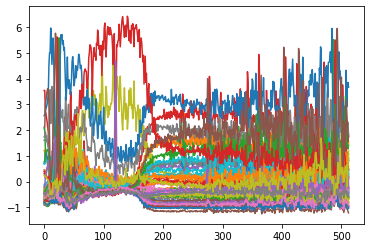

In [565]:
plt.plot(X[:,-513*2:-513].T)
plt.show()

### Training

In [576]:
tf.keras.backend.clear_session()

In [567]:
Callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1), 
            #tf.keras.callbacks.ModelCheckpoint(
            #   filepath='/tmp/checkpoint',
            #    save_weights_only=True,
            #    monitor='val_loss',
            #    mode='min',
            #    save_best_only=True,
            #    verbose = 1),
            ]

In [568]:
sc = StandardScaler()#MultiInputScaler(scaler=StandardScaler(), input_feats=n_feats, keep_dims=True)
m = MultiInputRegressor(model=DLSMR,loss=tf.keras.losses.mae,
                    optimizer=tf.keras.optimizers.Adam,
                    optimizer__learning_rate=1e-3,
                    epochs=200,batch_size=30,validation_split=0.1,
                    input_feats = n_feats,
                    #callbacks=Callbacks,
                    random_state=100,
                    verbose=0
                    )

In [569]:
X.shape

(49, 2106)

In [570]:
#reg = Pipeline([('scaler', sc), ('regressor', m)])
reg = Pipeline([('regressor', m)])

In [560]:
#reg.fit(X,y,**{'regressor__epochs':5})
reg.fit(X[1::,:],y[1::])
#reg.fit(X,y)

2022-08-21 20:38:11.025381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:38:14.484611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Pipeline(steps=[('regressor',
                 MultiInputRegressor(batch_size=30, epochs=200, input_feats=[270, 270, 270, 270, 513, 513], loss=<function mean_absolute_error at 0x296b35ee0>, model=<function DLSMR at 0x287354ca0>, optimizer=<class 'keras.optimizers.optimizer_v2.adam.Adam'>, optimizer__learning_rate=0.001, random_state=100, validation_split=0.1, verbose=0))])

In [561]:
reg.predict(X[0,:].reshape(1,-1))
#pred = reg.predict(X)

2022-08-21 20:38:38.170186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([0.06079124], dtype=float32)

In [562]:
y[0]

-0.08969488795874436

In [24]:
params = {'regressor__optimizer__learning_rate': [1e-2,1e-3]}
cv = GridSearchCV(estimator=reg,param_grid=params,cv=LeaveOneOut(),scoring='r2')

In [25]:
cv.fit(X,y,regressor__callbacks=Callbacks)

Epoch 1/5


2022-08-19 21:49:29.521853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.0319 - val_loss: 166.2079
Epoch 2/5


2022-08-19 21:49:30.057112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 106ms/step - loss: 167.8216 - val_loss: 137.6783
Epoch 3/5
1/1 [==============================] - 0s 76ms/step - loss: 138.2776 - val_loss: 128.1827
Epoch 4/5
1/1 [==============================] - 0s 80ms/step - loss: 129.8150 - val_loss: 121.9396
Epoch 5/5
1/1 [==============================] - 0s 70ms/step
Epoch 1/5


2022-08-19 21:49:30.614119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:31.431099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8874 - val_loss: 167.0474
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 167.3971

2022-08-19 21:49:31.957041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 90ms/step - loss: 167.3971 - val_loss: 150.6720
Epoch 3/5
1/1 [==============================] - 0s 64ms/step - loss: 154.5358 - val_loss: 124.0256
Epoch 4/5
1/1 [==============================] - 0s 62ms/step - loss: 128.4915 - val_loss: 120.1967
Epoch 5/5
1/1 [==============================] - 0s 63ms/step
Epoch 1/5


2022-08-19 21:49:32.483127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:32.969709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 966ms/step - loss: 134.8606 - val_loss: 163.5505
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 163.8363

2022-08-19 21:49:33.446292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 65ms/step - loss: 163.8363 - val_loss: 148.1044
Epoch 3/5
1/1 [==============================] - 0s 66ms/step - loss: 153.1238 - val_loss: 122.4824
Epoch 4/5
1/1 [==============================] - 0s 62ms/step - loss: 122.3348 - val_loss: 118.2741
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5


2022-08-19 21:49:33.918942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:34.417365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8889 - val_loss: 165.0951
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 165.2259

2022-08-19 21:49:34.962391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 59ms/step - loss: 165.2259 - val_loss: 139.1551
Epoch 3/5
1/1 [==============================] - 0s 69ms/step - loss: 142.6188 - val_loss: 130.8453
Epoch 4/5
1/1 [==============================] - 0s 65ms/step - loss: 130.0971 - val_loss: 122.3941
Epoch 5/5
1/1 [==============================] - 0s 63ms/step
Epoch 1/5


2022-08-19 21:49:35.420946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:35.913254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 953ms/step - loss: 134.9978 - val_loss: 167.6323
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 167.8325

2022-08-19 21:49:36.371792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 64ms/step - loss: 167.8325 - val_loss: 151.0501
Epoch 3/5
1/1 [==============================] - 0s 66ms/step - loss: 156.7277 - val_loss: 133.4064
Epoch 4/5
1/1 [==============================] - 0s 60ms/step - loss: 139.5345 - val_loss: 127.7784
Epoch 5/5
1/1 [==============================] - 0s 67ms/step


2022-08-19 21:49:36.830541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 1/5


2022-08-19 21:49:37.904230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 997ms/step - loss: 134.7744 - val_loss: 166.1886
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 169.0988

2022-08-19 21:49:38.398701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 73ms/step - loss: 169.0988 - val_loss: 150.0520
Epoch 3/5
1/1 [==============================] - 0s 108ms/step - loss: 145.1847 - val_loss: 146.7892
Epoch 4/5
1/1 [==============================] - 0s 67ms/step - loss: 147.5746 - val_loss: 138.1954
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5


2022-08-19 21:49:38.913897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:39.401877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.9636 - val_loss: 139.0726
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 142.3259

2022-08-19 21:49:39.955047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 56ms/step - loss: 142.3259 - val_loss: 140.8526
Epoch 3/5
1/1 [==============================] - 0s 67ms/step - loss: 145.4220 - val_loss: 127.8614
Epoch 4/5
1/1 [==============================] - 0s 80ms/step - loss: 130.7250 - val_loss: 116.0081
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5


2022-08-19 21:49:40.451853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:40.938082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.9779 - val_loss: 163.2346
Epoch 2/5


2022-08-19 21:49:41.428570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 75ms/step - loss: 162.5932 - val_loss: 134.9322
Epoch 3/5
1/1 [==============================] - 0s 64ms/step - loss: 136.1913 - val_loss: 130.6451
Epoch 4/5
1/1 [==============================] - 0s 75ms/step - loss: 134.2722 - val_loss: 122.4038
Epoch 5/5
1/1 [==============================] - 0s 63ms/step
Epoch 1/5


2022-08-19 21:49:41.983741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:42.838660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.0821 - val_loss: 165.2686
Epoch 2/5


2022-08-19 21:49:43.330960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 71ms/step - loss: 168.8161 - val_loss: 159.4064
Epoch 3/5
1/1 [==============================] - 0s 71ms/step - loss: 154.5017 - val_loss: 141.7115
Epoch 4/5
1/1 [==============================] - 0s 78ms/step - loss: 142.4805 - val_loss: 134.8857
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5


2022-08-19 21:49:43.852116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:44.366008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9641

2022-08-19 21:49:44.959637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.9641 - val_loss: 148.2606
Epoch 2/5
1/1 [==============================] - 0s 66ms/step - loss: 150.9212 - val_loss: 137.1094
Epoch 3/5
1/1 [==============================] - 0s 56ms/step - loss: 141.3716 - val_loss: 122.5593
Epoch 4/5
1/1 [==============================] - 0s 61ms/step - loss: 121.9528 - val_loss: 105.7248
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5


2022-08-19 21:49:45.483251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:45.971093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8821

2022-08-19 21:49:46.443795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8821 - val_loss: 136.0555
Epoch 2/5
1/1 [==============================] - 0s 62ms/step - loss: 136.1978 - val_loss: 139.8898
Epoch 3/5
1/1 [==============================] - 0s 120ms/step - loss: 141.8497 - val_loss: 125.5238
Epoch 4/5
1/1 [==============================] - 0s 59ms/step - loss: 129.0365 - val_loss: 114.8205
Epoch 5/5
1/1 [==============================] - 0s 70ms/step
Epoch 1/5


2022-08-19 21:49:47.013006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:47.518413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 992ms/step - loss: 135.0768 - val_loss: 170.9858
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 169.1765

2022-08-19 21:49:48.011767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 87ms/step - loss: 169.1765 - val_loss: 160.7728
Epoch 3/5
1/1 [==============================] - 0s 58ms/step - loss: 158.0416 - val_loss: 139.1665
Epoch 4/5
1/1 [==============================] - 0s 66ms/step - loss: 139.2654 - val_loss: 133.6266
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5


2022-08-19 21:49:48.489293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:49.558619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.9745 - val_loss: 165.1835
Epoch 2/5


2022-08-19 21:49:50.111141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 109ms/step - loss: 168.0484 - val_loss: 147.1273
Epoch 3/5
1/1 [==============================] - 0s 133ms/step - loss: 152.8110 - val_loss: 132.2289
Epoch 4/5
1/1 [==============================] - 0s 69ms/step - loss: 136.4217 - val_loss: 123.1633
Epoch 5/5
1/1 [==============================] - 0s 71ms/step
Epoch 1/5


2022-08-19 21:49:50.699392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:51.197941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8965 - val_loss: 167.6007
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 170.8718

2022-08-19 21:49:51.796824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 86ms/step - loss: 170.8718 - val_loss: 161.3279
Epoch 3/5
1/1 [==============================] - 0s 65ms/step - loss: 165.9558 - val_loss: 147.7142
Epoch 4/5
1/1 [==============================] - 0s 76ms/step - loss: 150.5494 - val_loss: 134.0340
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5


2022-08-19 21:49:52.301171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:52.788834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 995ms/step - loss: 134.9578 - val_loss: 165.4128
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 166.7902

2022-08-19 21:49:53.295939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 80ms/step - loss: 166.7902 - val_loss: 144.2506
Epoch 3/5
1/1 [==============================] - 0s 69ms/step - loss: 139.5086 - val_loss: 137.5489
Epoch 4/5
1/1 [==============================] - 0s 80ms/step - loss: 137.6698 - val_loss: 129.3463
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5


2022-08-19 21:49:53.801096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:54.293158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9455

2022-08-19 21:49:54.872885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.9455 - val_loss: 164.2685
Epoch 2/5
1/1 [==============================] - 0s 131ms/step - loss: 166.8730 - val_loss: 135.1673
Epoch 3/5
1/1 [==============================] - 0s 65ms/step - loss: 138.1785 - val_loss: 133.4845
Epoch 4/5
1/1 [==============================] - 0s 62ms/step - loss: 135.8219 - val_loss: 125.9939
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5


2022-08-19 21:49:55.484582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:56.817537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8283 - val_loss: 158.3163
Epoch 2/5


2022-08-19 21:49:57.373500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 101ms/step - loss: 162.5157 - val_loss: 150.1335
Epoch 3/5
1/1 [==============================] - 0s 127ms/step - loss: 150.6649 - val_loss: 131.0906
Epoch 4/5
1/1 [==============================] - 0s 68ms/step - loss: 130.1121 - val_loss: 108.9601
Epoch 5/5
1/1 [==============================] - 0s 63ms/step
Epoch 1/5


2022-08-19 21:49:57.965140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:49:58.456367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8687

2022-08-19 21:49:59.104874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8687 - val_loss: 139.6922
Epoch 2/5
1/1 [==============================] - 0s 74ms/step - loss: 141.8728 - val_loss: 140.5237
Epoch 3/5
1/1 [==============================] - 0s 75ms/step - loss: 141.3362 - val_loss: 124.2217
Epoch 4/5
1/1 [==============================] - 0s 54ms/step - loss: 125.9846 - val_loss: 109.4587
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5


2022-08-19 21:49:59.666144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:00.156330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.7997 - val_loss: 149.2668
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 158.1815

2022-08-19 21:50:00.761957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 81ms/step - loss: 158.1815 - val_loss: 146.5051
Epoch 3/5
1/1 [==============================] - 0s 73ms/step - loss: 146.7529 - val_loss: 128.8127
Epoch 4/5
1/1 [==============================] - 0s 69ms/step - loss: 129.2467 - val_loss: 110.7219
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5


2022-08-19 21:50:01.280184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:02.268969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.9294 - val_loss: 165.2388
Epoch 2/5


2022-08-19 21:50:02.932281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 93ms/step - loss: 165.5927 - val_loss: 155.0660
Epoch 3/5
1/1 [==============================] - 0s 74ms/step - loss: 152.3686 - val_loss: 128.9519
Epoch 4/5
1/1 [==============================] - 0s 91ms/step - loss: 131.3788 - val_loss: 120.0373
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5


2022-08-19 21:50:03.479837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:03.977563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.0165 - val_loss: 163.1886
Epoch 2/5


2022-08-19 21:50:04.640054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 117ms/step - loss: 164.5549 - val_loss: 138.2611
Epoch 3/5
1/1 [==============================] - 0s 80ms/step - loss: 136.6797 - val_loss: 135.3013
Epoch 4/5
1/1 [==============================] - 0s 86ms/step - loss: 136.5821 - val_loss: 125.6744
Epoch 5/5
1/1 [==============================] - 0s 85ms/step
Epoch 1/5


2022-08-19 21:50:05.213148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:05.735062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8645 - val_loss: 135.9666
Epoch 2/5


2022-08-19 21:50:06.248629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 101ms/step - loss: 132.6526 - val_loss: 139.3739
Epoch 3/5
1/1 [==============================] - 0s 71ms/step - loss: 138.6443 - val_loss: 109.2693
Epoch 4/5
1/1 [==============================] - 0s 54ms/step - loss: 110.1778 - val_loss: 106.9703
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5


2022-08-19 21:50:06.773952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:07.262355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.0532

2022-08-19 21:50:07.907100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.0532 - val_loss: 164.3509
Epoch 2/5
1/1 [==============================] - 0s 98ms/step - loss: 167.5459 - val_loss: 156.4844
Epoch 3/5
1/1 [==============================] - 0s 92ms/step - loss: 155.8519 - val_loss: 132.7454
Epoch 4/5
1/1 [==============================] - 0s 56ms/step - loss: 131.8427 - val_loss: 129.5686
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5


2022-08-19 21:50:08.492755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:09.860739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.0683

2022-08-19 21:50:10.383465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 135.0683 - val_loss: 166.4515
Epoch 2/5
1/1 [==============================] - 0s 131ms/step - loss: 169.5782 - val_loss: 159.5181
Epoch 3/5
1/1 [==============================] - 0s 63ms/step - loss: 162.3677 - val_loss: 131.2320
Epoch 4/5
1/1 [==============================] - 0s 87ms/step - loss: 133.0416 - val_loss: 128.9597
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5


2022-08-19 21:50:11.035557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:11.531111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.7429 - val_loss: 142.2946
Epoch 2/5


2022-08-19 21:50:12.180919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 117ms/step - loss: 148.5172 - val_loss: 139.6797
Epoch 3/5
1/1 [==============================] - 0s 67ms/step - loss: 141.7134 - val_loss: 123.0872
Epoch 4/5
1/1 [==============================] - 0s 61ms/step - loss: 125.7332 - val_loss: 108.2452
Epoch 5/5
1/1 [==============================] - 0s 77ms/step
Epoch 1/5


2022-08-19 21:50:12.760271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:13.269230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.2715 - val_loss: 170.9840
Epoch 2/5


2022-08-19 21:50:13.764151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 94ms/step - loss: 173.2095 - val_loss: 159.5299
Epoch 3/5
1/1 [==============================] - 0s 110ms/step - loss: 161.0991 - val_loss: 143.0061
Epoch 4/5
1/1 [==============================] - 0s 87ms/step - loss: 149.1110 - val_loss: 140.4074
Epoch 5/5
1/1 [==============================] - 0s 71ms/step
Epoch 1/5


2022-08-19 21:50:14.380288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:14.885123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8529

2022-08-19 21:50:15.533608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8529 - val_loss: 161.5591
Epoch 2/5
1/1 [==============================] - 0s 102ms/step - loss: 163.1729 - val_loss: 148.5845
Epoch 3/5
1/1 [==============================] - 0s 82ms/step - loss: 147.3994 - val_loss: 127.1092
Epoch 4/5
1/1 [==============================] - 0s 68ms/step - loss: 130.2615 - val_loss: 117.7480
Epoch 5/5
1/1 [==============================] - 0s 74ms/step


2022-08-19 21:50:16.133854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 1/5


2022-08-19 21:50:17.384873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.0012

2022-08-19 21:50:18.018643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.0012 - val_loss: 161.6898
Epoch 2/5
1/1 [==============================] - 0s 121ms/step - loss: 163.1526 - val_loss: 141.6991
Epoch 3/5
1/1 [==============================] - 0s 75ms/step - loss: 151.5064 - val_loss: 129.6269
Epoch 4/5
1/1 [==============================] - 0s 79ms/step - loss: 124.2137 - val_loss: 117.3564
Epoch 5/5
1/1 [==============================] - 0s 72ms/step
Epoch 1/5


2022-08-19 21:50:18.650608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:19.151380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9539

2022-08-19 21:50:19.788624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.9539 - val_loss: 160.4112
Epoch 2/5
1/1 [==============================] - 0s 87ms/step - loss: 162.7770 - val_loss: 135.3924
Epoch 3/5
1/1 [==============================] - 0s 68ms/step - loss: 136.4112 - val_loss: 129.0966
Epoch 4/5
1/1 [==============================] - 0s 74ms/step - loss: 127.7276 - val_loss: 118.9702
Epoch 5/5
1/1 [==============================] - 0s 72ms/step
Epoch 1/5


2022-08-19 21:50:20.374738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:20.870448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9579

2022-08-19 21:50:21.499858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.9579 - val_loss: 152.4090
Epoch 2/5
1/1 [==============================] - 0s 97ms/step - loss: 156.0281 - val_loss: 140.8145
Epoch 3/5
1/1 [==============================] - 0s 100ms/step - loss: 142.1385 - val_loss: 106.8337
Epoch 4/5
1/1 [==============================] - 0s 82ms/step - loss: 109.7508 - val_loss: 105.4665
Epoch 5/5
1/1 [==============================] - 0s 73ms/step
Epoch 1/5


2022-08-19 21:50:22.146171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:23.404820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8169

2022-08-19 21:50:24.077989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8169 - val_loss: 159.6289
Epoch 2/5
1/1 [==============================] - 0s 138ms/step - loss: 160.4055 - val_loss: 142.5645
Epoch 3/5
1/1 [==============================] - 0s 87ms/step - loss: 144.7204 - val_loss: 116.9571
Epoch 4/5
1/1 [==============================] - 0s 61ms/step - loss: 119.2257 - val_loss: 110.3402
Epoch 5/5
1/1 [==============================] - 0s 72ms/step
Epoch 1/5


2022-08-19 21:50:24.723222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:25.231660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.0386

2022-08-19 21:50:25.933747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.0386 - val_loss: 169.9516
Epoch 2/5
1/1 [==============================] - 0s 82ms/step - loss: 171.4671 - val_loss: 155.6385
Epoch 3/5
1/1 [==============================] - 0s 80ms/step - loss: 150.6197 - val_loss: 146.0420
Epoch 4/5
1/1 [==============================] - 0s 81ms/step - loss: 147.6726 - val_loss: 141.5080
Epoch 5/5
1/1 [==============================] - 0s 71ms/step
Epoch 1/5


2022-08-19 21:50:26.536418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:27.035390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.9653 - val_loss: 162.7883
Epoch 2/5


2022-08-19 21:50:27.684791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 126ms/step - loss: 164.8954 - val_loss: 140.8224
Epoch 3/5
1/1 [==============================] - 0s 79ms/step - loss: 138.7256 - val_loss: 131.0604
Epoch 4/5
1/1 [==============================] - 0s 85ms/step - loss: 133.5234 - val_loss: 123.0764
Epoch 5/5
1/1 [==============================] - 0s 74ms/step
Epoch 1/5


2022-08-19 21:50:28.274850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:28.782454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8435

2022-08-19 21:50:29.436313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8435 - val_loss: 160.2520
Epoch 2/5
1/1 [==============================] - 0s 107ms/step - loss: 163.7549 - val_loss: 131.4368
Epoch 3/5
1/1 [==============================] - 0s 91ms/step - loss: 131.9799 - val_loss: 125.2208
Epoch 4/5
1/1 [==============================] - 0s 70ms/step - loss: 123.1839 - val_loss: 129.5208
Epoch 5/5
1/1 [==============================] - 0s 72ms/step
Epoch 1/5


2022-08-19 21:50:30.115370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:31.292892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8921

2022-08-19 21:50:32.075726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8921 - val_loss: 135.7512
Epoch 2/5
1/1 [==============================] - 0s 111ms/step - loss: 131.2063 - val_loss: 139.8995
Epoch 3/5
1/1 [==============================] - 0s 133ms/step - loss: 141.2904 - val_loss: 120.1615
Epoch 4/5
1/1 [==============================] - 0s 59ms/step - loss: 122.6518 - val_loss: 105.9828
Epoch 5/5
1/1 [==============================] - 0s 73ms/step
Epoch 1/5


2022-08-19 21:50:32.763801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:33.282804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.2710

2022-08-19 21:50:33.986721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.2710 - val_loss: 170.4542
Epoch 2/5
1/1 [==============================] - 0s 167ms/step - loss: 171.4344 - val_loss: 168.1468
Epoch 3/5
1/1 [==============================] - 0s 88ms/step - loss: 169.4258 - val_loss: 149.8983
Epoch 4/5
1/1 [==============================] - 0s 92ms/step - loss: 148.7319 - val_loss: 139.0630
Epoch 5/5
1/1 [==============================] - 0s 81ms/step
Epoch 1/5


2022-08-19 21:50:34.712559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:35.224381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9187

2022-08-19 21:50:35.935917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.9187 - val_loss: 140.2683
Epoch 2/5
1/1 [==============================] - 0s 97ms/step - loss: 132.7207 - val_loss: 130.4383
Epoch 3/5
1/1 [==============================] - 0s 82ms/step - loss: 133.1383 - val_loss: 108.6138
Epoch 4/5
1/1 [==============================] - 0s 88ms/step - loss: 109.0057 - val_loss: 108.2554
Epoch 5/5
1/1 [==============================] - 0s 72ms/step
Epoch 1/5


2022-08-19 21:50:36.550077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:37.057424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8248

2022-08-19 21:50:37.745592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8248 - val_loss: 132.7465
Epoch 2/5
1/1 [==============================] - 0s 171ms/step - loss: 140.8093 - val_loss: 145.0905
Epoch 3/5
1/1 [==============================] - 0s 63ms/step - loss: 143.9812 - val_loss: 129.0979
Epoch 4/5
1/1 [==============================] - 0s 83ms/step - loss: 129.5735 - val_loss: 114.1106
Epoch 5/5
1/1 [==============================] - 0s 73ms/step
Epoch 1/5


2022-08-19 21:50:38.436360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:39.839749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.0013

2022-08-19 21:50:40.499106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 135.0013 - val_loss: 167.1221
Epoch 2/5
1/1 [==============================] - 0s 91ms/step - loss: 169.5340 - val_loss: 151.7377
Epoch 3/5
1/1 [==============================] - 0s 114ms/step - loss: 154.7781 - val_loss: 136.4657
Epoch 4/5
1/1 [==============================] - 0s 129ms/step - loss: 137.8729 - val_loss: 126.9371
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5


2022-08-19 21:50:41.205803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:41.702201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.7568

2022-08-19 21:50:42.328589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.7568 - val_loss: 162.2785
Epoch 2/5
1/1 [==============================] - 0s 111ms/step - loss: 162.4035 - val_loss: 136.1328
Epoch 3/5
1/1 [==============================] - 0s 92ms/step - loss: 141.1446 - val_loss: 121.9360
Epoch 4/5
1/1 [==============================] - 0s 71ms/step - loss: 127.1354 - val_loss: 115.3122
Epoch 5/5
1/1 [==============================] - 0s 76ms/step
Epoch 1/5


2022-08-19 21:50:42.992920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:43.493083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.0047

2022-08-19 21:50:44.137959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.0047 - val_loss: 157.9238
Epoch 2/5
1/1 [==============================] - 0s 89ms/step - loss: 158.3300 - val_loss: 135.9837
Epoch 3/5
1/1 [==============================] - 0s 89ms/step - loss: 133.2957 - val_loss: 118.7473
Epoch 4/5
1/1 [==============================] - 0s 103ms/step - loss: 117.5060 - val_loss: 113.2570
Epoch 5/5
1/1 [==============================] - 0s 102ms/step
Epoch 1/5


2022-08-19 21:50:44.800860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:45.344439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8551

2022-08-19 21:50:46.663039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8551 - val_loss: 159.1410
Epoch 2/5
1/1 [==============================] - 0s 236ms/step - loss: 161.2044 - val_loss: 134.2922
Epoch 3/5
1/1 [==============================] - 0s 99ms/step - loss: 139.5292 - val_loss: 121.5347
Epoch 4/5
1/1 [==============================] - 0s 63ms/step - loss: 120.0410 - val_loss: 114.8576
Epoch 5/5
1/1 [==============================] - 0s 82ms/step
Epoch 1/5


2022-08-19 21:50:47.455115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:48.001007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.0370

2022-08-19 21:50:48.691106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.0370 - val_loss: 167.4985
Epoch 2/5
1/1 [==============================] - 0s 94ms/step - loss: 171.5807 - val_loss: 160.1431
Epoch 3/5
1/1 [==============================] - 0s 82ms/step - loss: 164.9340 - val_loss: 137.6403
Epoch 4/5
1/1 [==============================] - 0s 74ms/step - loss: 137.8563 - val_loss: 140.0987
Epoch 5/5
1/1 [==============================] - 0s 79ms/step
Epoch 1/5


2022-08-19 21:50:49.349483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:49.860775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9121

2022-08-19 21:50:50.549944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.9121 - val_loss: 140.5434
Epoch 2/5
1/1 [==============================] - 0s 103ms/step - loss: 151.8828 - val_loss: 146.5044
Epoch 3/5
1/1 [==============================] - 0s 70ms/step - loss: 146.7910 - val_loss: 129.8544
Epoch 4/5
1/1 [==============================] - 0s 94ms/step - loss: 129.9700 - val_loss: 113.7003
Epoch 5/5
1/1 [==============================] - 0s 74ms/step
Epoch 1/5


2022-08-19 21:50:51.165901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:51.681215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8496

2022-08-19 21:50:52.341763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8496 - val_loss: 162.7077
Epoch 2/5
1/1 [==============================] - 0s 151ms/step - loss: 164.3561 - val_loss: 142.0288
Epoch 3/5
1/1 [==============================] - 0s 95ms/step - loss: 133.0855 - val_loss: 116.8290
Epoch 4/5
1/1 [==============================] - 0s 83ms/step - loss: 116.8377 - val_loss: 116.0873
Epoch 5/5
1/1 [==============================] - 0s 74ms/step
Epoch 1/5


2022-08-19 21:50:53.044045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:54.324080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.0945

2022-08-19 21:50:55.050480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 135.0945 - val_loss: 164.3726
Epoch 2/5
1/1 [==============================] - 0s 115ms/step - loss: 167.0350 - val_loss: 140.6889
Epoch 3/5
1/1 [==============================] - 0s 81ms/step - loss: 138.4838 - val_loss: 129.0494
Epoch 4/5
1/1 [==============================] - 0s 93ms/step - loss: 130.6459 - val_loss: 127.9640
Epoch 5/5
1/1 [==============================] - 0s 80ms/step
Epoch 1/5


2022-08-19 21:50:55.819948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:56.342821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.2128

2022-08-19 21:50:56.991972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.2128 - val_loss: 169.0380
Epoch 2/5
1/1 [==============================] - 0s 161ms/step - loss: 172.1618 - val_loss: 163.2440
Epoch 3/5
1/1 [==============================] - 0s 78ms/step - loss: 152.2225 - val_loss: 146.2571
Epoch 4/5
1/1 [==============================] - 0s 75ms/step - loss: 147.9944 - val_loss: 140.1018
Epoch 5/5
1/1 [==============================] - 0s 75ms/step
Epoch 1/5


2022-08-19 21:50:57.677574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:58.194092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.2997

2022-08-19 21:50:58.881383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.2997 - val_loss: 168.4224
Epoch 2/5
1/1 [==============================] - 0s 84ms/step - loss: 170.3096 - val_loss: 162.8376
Epoch 3/5
1/1 [==============================] - 0s 93ms/step - loss: 157.3213 - val_loss: 143.5583
Epoch 4/5
1/1 [==============================] - 0s 66ms/step - loss: 144.9755 - val_loss: 139.2159
Epoch 5/5
1/1 [==============================] - 0s 75ms/step
Epoch 1/5


2022-08-19 21:50:59.481178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:50:59.987153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8226

2022-08-19 21:51:00.667650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8226 - val_loss: 140.4446
Epoch 2/5
1/1 [==============================] - 0s 119ms/step - loss: 138.0402 - val_loss: 142.1857
Epoch 3/5
1/1 [==============================] - 0s 97ms/step - loss: 140.9759 - val_loss: 127.3642
Epoch 4/5
1/1 [==============================] - 0s 80ms/step - loss: 127.0097 - val_loss: 112.6420
Epoch 5/5
1/1 [==============================] - 0s 82ms/step
Epoch 1/5


2022-08-19 21:51:01.451424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:02.876702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8617

2022-08-19 21:51:03.548306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8617 - val_loss: 141.5886
Epoch 2/5
1/1 [==============================] - 0s 117ms/step - loss: 143.2960 - val_loss: 137.0257
Epoch 3/5
1/1 [==============================] - 0s 104ms/step - loss: 138.3745 - val_loss: 132.0594
Epoch 4/5
1/1 [==============================] - 0s 114ms/step - loss: 132.4432 - val_loss: 127.7809
Epoch 5/5
1/1 [==============================] - 0s 74ms/step
Epoch 1/5


2022-08-19 21:51:04.277177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:04.785738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9738

2022-08-19 21:51:05.484767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.9738 - val_loss: 151.6358
Epoch 2/5
1/1 [==============================] - 0s 99ms/step - loss: 155.3803 - val_loss: 141.2062
Epoch 3/5
1/1 [==============================] - 0s 100ms/step - loss: 143.3148 - val_loss: 130.6077
Epoch 4/5
1/1 [==============================] - 0s 116ms/step - loss: 133.2306 - val_loss: 128.0592
Epoch 5/5
1/1 [==============================] - 0s 79ms/step
Epoch 1/5


2022-08-19 21:51:06.196932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:06.714762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8610

2022-08-19 21:51:07.383048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8610 - val_loss: 149.8432
Epoch 2/5
1/1 [==============================] - 0s 99ms/step - loss: 152.7701 - val_loss: 135.3541
Epoch 3/5
1/1 [==============================] - 0s 138ms/step - loss: 135.4642 - val_loss: 136.0594
Epoch 4/5
1/1 [==============================] - 0s 66ms/step - loss: 139.7269 - val_loss: 132.5639
Epoch 5/5
1/1 [==============================] - 0s 74ms/step
Epoch 1/5


2022-08-19 21:51:08.044451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:08.544966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.6996

2022-08-19 21:51:09.198427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.6996 - val_loss: 136.2252
Epoch 2/5
1/1 [==============================] - 0s 137ms/step - loss: 138.8194 - val_loss: 141.3189
Epoch 3/5
1/1 [==============================] - 0s 99ms/step - loss: 143.5777 - val_loss: 134.6865
Epoch 4/5
1/1 [==============================] - 0s 74ms/step - loss: 135.2788 - val_loss: 125.0453
Epoch 5/5
1/1 [==============================] - 0s 76ms/step


2022-08-19 21:51:09.910180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 1/5


2022-08-19 21:51:11.324225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8100

2022-08-19 21:51:12.037139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8100 - val_loss: 155.7901
Epoch 2/5
1/1 [==============================] - 0s 112ms/step - loss: 159.8761 - val_loss: 147.4749
Epoch 3/5
1/1 [==============================] - 0s 114ms/step - loss: 150.2456 - val_loss: 131.9768
Epoch 4/5
1/1 [==============================] - 0s 97ms/step - loss: 132.1023 - val_loss: 143.5950
Epoch 5/5
1/1 [==============================] - 0s 76ms/step
Epoch 1/5


2022-08-19 21:51:12.779272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:13.311182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.0930

2022-08-19 21:51:13.989383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.0930 - val_loss: 153.8176
Epoch 2/5
1/1 [==============================] - 0s 98ms/step - loss: 157.6158 - val_loss: 145.4551
Epoch 3/5
1/1 [==============================] - 0s 100ms/step - loss: 148.2756 - val_loss: 131.1855
Epoch 4/5
1/1 [==============================] - 0s 104ms/step - loss: 132.6845 - val_loss: 139.8898
Epoch 5/5
1/1 [==============================] - 0s 74ms/step
Epoch 1/5


2022-08-19 21:51:14.684821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:15.210299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.0659

2022-08-19 21:51:15.944779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.0659 - val_loss: 156.2141
Epoch 2/5
1/1 [==============================] - 0s 142ms/step - loss: 159.4407 - val_loss: 148.9659
Epoch 3/5
1/1 [==============================] - 0s 100ms/step - loss: 151.1594 - val_loss: 132.7746
Epoch 4/5
1/1 [==============================] - 0s 113ms/step - loss: 133.8866 - val_loss: 141.3250
Epoch 5/5
1/1 [==============================] - 0s 136ms/step


2022-08-19 21:51:16.698993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 1/5


2022-08-19 21:51:18.099797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.7811

2022-08-19 21:51:18.838565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.7811 - val_loss: 144.3583
Epoch 2/5
1/1 [==============================] - 0s 216ms/step - loss: 146.5758 - val_loss: 133.7797
Epoch 3/5
1/1 [==============================] - 0s 175ms/step - loss: 135.5806 - val_loss: 129.5298
Epoch 4/5
1/1 [==============================] - 0s 59ms/step - loss: 130.7278 - val_loss: 126.7799
Epoch 5/5
1/1 [==============================] - 0s 83ms/step
Epoch 1/5


2022-08-19 21:51:19.920072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:20.465852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8106

2022-08-19 21:51:21.202378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8106 - val_loss: 154.1840
Epoch 2/5
1/1 [==============================] - 0s 132ms/step - loss: 157.2813 - val_loss: 143.1383
Epoch 3/5
1/1 [==============================] - 0s 125ms/step - loss: 145.3568 - val_loss: 131.8417
Epoch 4/5
1/1 [==============================] - 0s 151ms/step - loss: 131.8625 - val_loss: 131.0175
Epoch 5/5
1/1 [==============================] - 0s 109ms/step
Epoch 1/5


2022-08-19 21:51:22.139622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:22.726184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.7596

2022-08-19 21:51:23.497390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.7596 - val_loss: 151.1351
Epoch 2/5
1/1 [==============================] - 0s 212ms/step - loss: 154.5044 - val_loss: 138.8074
Epoch 3/5
1/1 [==============================] - 0s 108ms/step - loss: 139.9237 - val_loss: 134.9587
Epoch 4/5
1/1 [==============================] - 0s 78ms/step - loss: 136.3094 - val_loss: 132.2424
Epoch 5/5
1/1 [==============================] - 0s 81ms/step
Epoch 1/5


2022-08-19 21:51:24.380248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:24.921787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8129

2022-08-19 21:51:25.650217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8129 - val_loss: 141.3659
Epoch 2/5
1/1 [==============================] - 0s 148ms/step - loss: 144.3430 - val_loss: 137.6717
Epoch 3/5
1/1 [==============================] - 0s 185ms/step - loss: 141.0920 - val_loss: 132.9298
Epoch 4/5
1/1 [==============================] - 0s 96ms/step - loss: 135.0017 - val_loss: 127.2711
Epoch 5/5
1/1 [==============================] - 0s 102ms/step
Epoch 1/5


2022-08-19 21:51:26.653116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:28.128202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.0658

2022-08-19 21:51:28.795247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 135.0658 - val_loss: 153.1322
Epoch 2/5
1/1 [==============================] - 0s 116ms/step - loss: 156.3237 - val_loss: 142.7555
Epoch 3/5
1/1 [==============================] - 0s 172ms/step - loss: 144.7095 - val_loss: 132.5669
Epoch 4/5
1/1 [==============================] - 0s 90ms/step - loss: 132.8600 - val_loss: 131.7080
Epoch 5/5
1/1 [==============================] - 0s 85ms/step
Epoch 1/5


2022-08-19 21:51:29.630252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:30.150498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9773

2022-08-19 21:51:30.819459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.9773 - val_loss: 151.4048
Epoch 2/5
1/1 [==============================] - 0s 106ms/step - loss: 154.4467 - val_loss: 139.9764
Epoch 3/5
1/1 [==============================] - 0s 116ms/step - loss: 142.5848 - val_loss: 132.1686
Epoch 4/5
1/1 [==============================] - 0s 130ms/step - loss: 134.1537 - val_loss: 129.2874
Epoch 5/5
1/1 [==============================] - 0s 76ms/step
Epoch 1/5


2022-08-19 21:51:31.564470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:32.092081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9170

2022-08-19 21:51:32.959040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.9170 - val_loss: 145.4293
Epoch 2/5
1/1 [==============================] - 0s 162ms/step - loss: 148.1217 - val_loss: 132.8780
Epoch 3/5
1/1 [==============================] - 0s 94ms/step - loss: 133.9017 - val_loss: 128.8721
Epoch 4/5
1/1 [==============================] - 0s 87ms/step - loss: 129.9549 - val_loss: 125.9575
Epoch 5/5
1/1 [==============================] - 0s 91ms/step
Epoch 1/5


2022-08-19 21:51:33.782411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:34.351871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.1389

2022-08-19 21:51:35.032782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.1389 - val_loss: 155.2253
Epoch 2/5
1/1 [==============================] - 0s 106ms/step - loss: 158.8326 - val_loss: 147.9368
Epoch 3/5
1/1 [==============================] - 0s 73ms/step - loss: 150.6825 - val_loss: 132.9671
Epoch 4/5
1/1 [==============================] - 0s 84ms/step - loss: 134.7815 - val_loss: 140.4752
Epoch 5/5
1/1 [==============================] - 0s 74ms/step
Epoch 1/5


2022-08-19 21:51:35.685704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:37.114715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9696

2022-08-19 21:51:37.797384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.9696 - val_loss: 153.9105
Epoch 2/5
1/1 [==============================] - 0s 178ms/step - loss: 158.9164 - val_loss: 143.5160
Epoch 3/5
1/1 [==============================] - 0s 148ms/step - loss: 146.6573 - val_loss: 130.3653
Epoch 4/5
1/1 [==============================] - 0s 76ms/step - loss: 130.8525 - val_loss: 130.8884
Epoch 5/5
1/1 [==============================] - 0s 80ms/step
Epoch 1/5


2022-08-19 21:51:38.606814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:39.123628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.7973

2022-08-19 21:51:39.809844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.7973 - val_loss: 141.2249
Epoch 2/5
1/1 [==============================] - 0s 100ms/step - loss: 143.3603 - val_loss: 136.7093
Epoch 3/5
1/1 [==============================] - 0s 95ms/step - loss: 141.6053 - val_loss: 131.9389
Epoch 4/5
1/1 [==============================] - 0s 81ms/step - loss: 134.9516 - val_loss: 126.9568
Epoch 5/5
1/1 [==============================] - 0s 82ms/step
Epoch 1/5


2022-08-19 21:51:40.476460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:40.995239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.0643

2022-08-19 21:51:41.807878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.0643 - val_loss: 155.4975
Epoch 2/5
1/1 [==============================] - 0s 92ms/step - loss: 158.8493 - val_loss: 149.0690
Epoch 3/5
1/1 [==============================] - 0s 108ms/step - loss: 151.2986 - val_loss: 134.1165
Epoch 4/5
1/1 [==============================] - 0s 63ms/step - loss: 134.5556 - val_loss: 142.5104
Epoch 5/5
1/1 [==============================] - 0s 79ms/step
Epoch 1/5


2022-08-19 21:51:42.502372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:43.015967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.7316

2022-08-19 21:51:43.720621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.7316 - val_loss: 139.5736
Epoch 2/5
1/1 [==============================] - 0s 153ms/step - loss: 140.3936 - val_loss: 137.8547
Epoch 3/5
1/1 [==============================] - 0s 91ms/step - loss: 140.1265 - val_loss: 132.4297
Epoch 4/5
1/1 [==============================] - 0s 143ms/step - loss: 134.0676 - val_loss: 126.4604
Epoch 5/5
1/1 [==============================] - 0s 83ms/step


2022-08-19 21:51:44.539364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 1/5


2022-08-19 21:51:46.004984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8723

2022-08-19 21:51:46.684609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8723 - val_loss: 151.4074
Epoch 2/5
1/1 [==============================] - 0s 174ms/step - loss: 155.1641 - val_loss: 140.7738
Epoch 3/5
1/1 [==============================] - 0s 112ms/step - loss: 143.2478 - val_loss: 131.4993
Epoch 4/5
1/1 [==============================] - 0s 118ms/step - loss: 132.3313 - val_loss: 129.3861
Epoch 5/5
1/1 [==============================] - 0s 90ms/step
Epoch 1/5


2022-08-19 21:51:47.482164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:48.012512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9561

2022-08-19 21:51:48.753529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.9561 - val_loss: 149.1765
Epoch 2/5
1/1 [==============================] - 0s 120ms/step - loss: 153.3348 - val_loss: 136.5785
Epoch 3/5
1/1 [==============================] - 0s 121ms/step - loss: 139.1675 - val_loss: 136.8136
Epoch 4/5
1/1 [==============================] - 0s 66ms/step - loss: 139.0677 - val_loss: 133.4011
Epoch 5/5
1/1 [==============================] - 0s 86ms/step
Epoch 1/5


2022-08-19 21:51:49.561221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:50.090373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.0633

2022-08-19 21:51:50.763683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 135.0633 - val_loss: 151.9003
Epoch 2/5
1/1 [==============================] - 0s 139ms/step - loss: 155.5400 - val_loss: 140.0437
Epoch 3/5
1/1 [==============================] - 0s 128ms/step - loss: 142.6093 - val_loss: 132.6698
Epoch 4/5
1/1 [==============================] - 0s 87ms/step - loss: 134.6566 - val_loss: 129.2691
Epoch 5/5
1/1 [==============================] - 0s 83ms/step
Epoch 1/5


2022-08-19 21:51:51.549578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:52.093894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.7742

2022-08-19 21:51:53.623737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.7742 - val_loss: 145.9598
Epoch 2/5
1/1 [==============================] - 0s 274ms/step - loss: 147.3601 - val_loss: 133.0867
Epoch 3/5
1/1 [==============================] - 0s 88ms/step - loss: 134.3082 - val_loss: 128.3775
Epoch 4/5
1/1 [==============================] - 0s 126ms/step - loss: 129.5524 - val_loss: 127.2682
Epoch 5/5
1/1 [==============================] - 0s 102ms/step
Epoch 1/5


2022-08-19 21:51:54.653071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:55.196999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8833

2022-08-19 21:51:56.120374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8833 - val_loss: 138.3109
Epoch 2/5
1/1 [==============================] - 0s 134ms/step - loss: 138.4327 - val_loss: 141.6002
Epoch 3/5
1/1 [==============================] - 0s 102ms/step - loss: 144.3306 - val_loss: 131.1803
Epoch 4/5
1/1 [==============================] - 0s 89ms/step - loss: 132.8539 - val_loss: 130.3233
Epoch 5/5
1/1 [==============================] - 0s 133ms/step


2022-08-19 21:51:56.921374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 1/5


2022-08-19 21:51:57.499458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.6852

2022-08-19 21:51:58.422903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.6852 - val_loss: 134.9600
Epoch 2/5
1/1 [==============================] - 0s 147ms/step - loss: 136.1696 - val_loss: 141.7013
Epoch 3/5
1/1 [==============================] - 0s 93ms/step - loss: 145.0225 - val_loss: 133.5059
Epoch 4/5
1/1 [==============================] - 0s 117ms/step - loss: 135.0231 - val_loss: 125.1868
Epoch 5/5
1/1 [==============================] - 0s 89ms/step
Epoch 1/5


2022-08-19 21:51:59.241342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:51:59.758851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8082

2022-08-19 21:52:00.672680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8082 - val_loss: 143.5610
Epoch 2/5
1/1 [==============================] - 0s 150ms/step - loss: 146.1068 - val_loss: 134.2585
Epoch 3/5
1/1 [==============================] - 0s 106ms/step - loss: 135.4480 - val_loss: 129.4579
Epoch 4/5
1/1 [==============================] - 0s 114ms/step - loss: 130.3338 - val_loss: 126.5414
Epoch 5/5
1/1 [==============================] - 0s 96ms/step
Epoch 1/5


2022-08-19 21:52:01.577951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:03.081285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.0674

2022-08-19 21:52:04.063571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step - loss: 135.0674 - val_loss: 154.4551
Epoch 2/5
1/1 [==============================] - 0s 199ms/step - loss: 157.8151 - val_loss: 147.8346
Epoch 3/5
1/1 [==============================] - 0s 133ms/step - loss: 150.3260 - val_loss: 134.5891
Epoch 4/5
1/1 [==============================] - 0s 138ms/step - loss: 135.5629 - val_loss: 139.7402
Epoch 5/5
1/1 [==============================] - 0s 82ms/step
Epoch 1/5


2022-08-19 21:52:05.047883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:05.590274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8494

2022-08-19 21:52:06.535402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8494 - val_loss: 148.9609
Epoch 2/5
1/1 [==============================] - 0s 152ms/step - loss: 150.9448 - val_loss: 133.9883
Epoch 3/5
1/1 [==============================] - 0s 77ms/step - loss: 134.9036 - val_loss: 137.2771
Epoch 4/5
1/1 [==============================] - 0s 119ms/step - loss: 140.9063 - val_loss: 132.8861
Epoch 5/5
1/1 [==============================] - 0s 79ms/step
Epoch 1/5


2022-08-19 21:52:07.261288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:07.770631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9478

2022-08-19 21:52:08.673534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.9478 - val_loss: 154.0801
Epoch 2/5
1/1 [==============================] - 0s 133ms/step - loss: 156.9529 - val_loss: 145.5191
Epoch 3/5
1/1 [==============================] - 0s 116ms/step - loss: 147.1033 - val_loss: 130.1452
Epoch 4/5
1/1 [==============================] - 0s 102ms/step - loss: 130.4426 - val_loss: 140.4157
Epoch 5/5
1/1 [==============================] - 0s 90ms/step
Epoch 1/5


2022-08-19 21:52:09.370792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:09.893701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.7776

2022-08-19 21:52:10.813047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.7776 - val_loss: 145.5053
Epoch 2/5
1/1 [==============================] - 0s 159ms/step - loss: 147.9671 - val_loss: 130.0864
Epoch 3/5
1/1 [==============================] - 0s 152ms/step - loss: 132.7439 - val_loss: 129.1693
Epoch 4/5
1/1 [==============================] - 0s 98ms/step - loss: 131.6031 - val_loss: 125.7923
Epoch 5/5
1/1 [==============================] - 0s 96ms/step
Epoch 1/5


2022-08-19 21:52:11.759809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:13.256984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9302

2022-08-19 21:52:14.186952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step - loss: 134.9302 - val_loss: 152.3075
Epoch 2/5
1/1 [==============================] - 0s 164ms/step - loss: 155.2420 - val_loss: 139.6341
Epoch 3/5
1/1 [==============================] - 0s 184ms/step - loss: 141.5282 - val_loss: 133.7738
Epoch 4/5
1/1 [==============================] - 0s 96ms/step - loss: 136.8704 - val_loss: 130.9745
Epoch 5/5
1/1 [==============================] - 0s 87ms/step
Epoch 1/5


2022-08-19 21:52:15.189504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:15.711386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8709

2022-08-19 21:52:16.636888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8709 - val_loss: 153.7260
Epoch 2/5
1/1 [==============================] - 0s 144ms/step - loss: 158.1377 - val_loss: 145.8400
Epoch 3/5
1/1 [==============================] - 0s 108ms/step - loss: 148.8875 - val_loss: 131.0838
Epoch 4/5
1/1 [==============================] - 0s 134ms/step - loss: 132.2878 - val_loss: 139.7630
Epoch 5/5
1/1 [==============================] - 0s 92ms/step
Epoch 1/5


2022-08-19 21:52:17.601886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:18.132158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8376

2022-08-19 21:52:19.100509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8376 - val_loss: 149.0219
Epoch 2/5
1/1 [==============================] - 0s 84ms/step - loss: 152.5125 - val_loss: 135.5636
Epoch 3/5
1/1 [==============================] - 0s 77ms/step - loss: 136.6167 - val_loss: 137.8858
Epoch 4/5
1/1 [==============================] - 0s 133ms/step - loss: 139.5076 - val_loss: 134.0947
Epoch 5/5
1/1 [==============================] - 0s 76ms/step
Epoch 1/5


2022-08-19 21:52:19.785665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:20.293320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9048

2022-08-19 21:52:22.015097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step - loss: 134.9048 - val_loss: 151.3583
Epoch 2/5
1/1 [==============================] - 0s 230ms/step - loss: 155.3489 - val_loss: 138.9654
Epoch 3/5
1/1 [==============================] - 0s 136ms/step - loss: 141.7127 - val_loss: 133.5790
Epoch 4/5
1/1 [==============================] - 0s 110ms/step - loss: 134.9575 - val_loss: 130.9243
Epoch 5/5
1/1 [==============================] - 0s 100ms/step
Epoch 1/5


2022-08-19 21:52:23.170580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:23.732554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8998

2022-08-19 21:52:24.457420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.8998 - val_loss: 149.8472
Epoch 2/5
1/1 [==============================] - 0s 193ms/step - loss: 152.6592 - val_loss: 136.1969
Epoch 3/5
1/1 [==============================] - 0s 74ms/step - loss: 136.7941 - val_loss: 135.9124
Epoch 4/5
1/1 [==============================] - 0s 103ms/step - loss: 138.0561 - val_loss: 131.9981
Epoch 5/5
1/1 [==============================] - 0s 101ms/step
Epoch 1/5


2022-08-19 21:52:25.354584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:25.913341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.7059

2022-08-19 21:52:26.884630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.7059 - val_loss: 154.4214
Epoch 2/5
1/1 [==============================] - 0s 185ms/step - loss: 157.3225 - val_loss: 145.0349
Epoch 3/5
1/1 [==============================] - 0s 132ms/step - loss: 146.4573 - val_loss: 129.6045
Epoch 4/5
1/1 [==============================] - 0s 107ms/step - loss: 130.7403 - val_loss: 138.4969
Epoch 5/5
1/1 [==============================] - 0s 88ms/step
Epoch 1/5


2022-08-19 21:52:27.696379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:28.230233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8026

2022-08-19 21:52:29.192899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8026 - val_loss: 138.5794
Epoch 2/5
1/1 [==============================] - 0s 183ms/step - loss: 139.7149 - val_loss: 137.0693
Epoch 3/5
1/1 [==============================] - 0s 85ms/step - loss: 140.7625 - val_loss: 130.9831
Epoch 4/5
1/1 [==============================] - 0s 164ms/step - loss: 133.3535 - val_loss: 127.9135
Epoch 5/5
1/1 [==============================] - 0s 85ms/step
Epoch 1/5


2022-08-19 21:52:30.209974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:31.671650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.1265

2022-08-19 21:52:32.772713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step - loss: 135.1265 - val_loss: 154.9018
Epoch 2/5
1/1 [==============================] - 0s 164ms/step - loss: 159.7196 - val_loss: 148.4264
Epoch 3/5
1/1 [==============================] - 0s 150ms/step - loss: 152.1945 - val_loss: 133.7249
Epoch 4/5
1/1 [==============================] - 0s 136ms/step - loss: 135.3107 - val_loss: 140.8194
Epoch 5/5
1/1 [==============================] - 0s 90ms/step
Epoch 1/5


2022-08-19 21:52:33.634913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:34.183479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.7323

2022-08-19 21:52:35.210138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.7323 - val_loss: 148.9654
Epoch 2/5
1/1 [==============================] - 0s 165ms/step - loss: 152.9500 - val_loss: 133.9171
Epoch 3/5
1/1 [==============================] - 0s 109ms/step - loss: 136.0642 - val_loss: 138.6724
Epoch 4/5
1/1 [==============================] - 0s 114ms/step - loss: 140.1943 - val_loss: 135.2907
Epoch 5/5
1/1 [==============================] - 0s 78ms/step
Epoch 1/5


2022-08-19 21:52:36.104102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:36.614763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8675

2022-08-19 21:52:37.647162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8675 - val_loss: 146.7126
Epoch 2/5
1/1 [==============================] - 0s 172ms/step - loss: 150.9120 - val_loss: 134.3584
Epoch 3/5
1/1 [==============================] - 0s 102ms/step - loss: 135.9153 - val_loss: 138.6984
Epoch 4/5
1/1 [==============================] - 0s 85ms/step - loss: 140.4757 - val_loss: 133.6783
Epoch 5/5
1/1 [==============================] - 0s 89ms/step
Epoch 1/5


2022-08-19 21:52:38.392029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:38.922623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9228

2022-08-19 21:52:39.883205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.9228 - val_loss: 141.2278
Epoch 2/5
1/1 [==============================] - 0s 213ms/step - loss: 144.8594 - val_loss: 136.7140
Epoch 3/5
1/1 [==============================] - 0s 135ms/step - loss: 140.1229 - val_loss: 131.5022
Epoch 4/5
1/1 [==============================] - 0s 84ms/step - loss: 133.8707 - val_loss: 127.9645
Epoch 5/5
1/1 [==============================] - 0s 101ms/step
Epoch 1/5


2022-08-19 21:52:40.948739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:42.374995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.1726

2022-08-19 21:52:43.130491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 135.1726 - val_loss: 154.7191
Epoch 2/5
1/1 [==============================] - 0s 197ms/step - loss: 159.0578 - val_loss: 147.2084
Epoch 3/5
1/1 [==============================] - 0s 117ms/step - loss: 150.2552 - val_loss: 132.6025
Epoch 4/5
1/1 [==============================] - 0s 162ms/step - loss: 133.5166 - val_loss: 141.8989
Epoch 5/5
1/1 [==============================] - 0s 122ms/step


2022-08-19 21:52:44.150746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 1/5


2022-08-19 21:52:44.738769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9565

2022-08-19 21:52:45.479115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 134.9565 - val_loss: 152.3143
Epoch 2/5
1/1 [==============================] - 0s 189ms/step - loss: 155.6267 - val_loss: 141.2118
Epoch 3/5
1/1 [==============================] - 0s 137ms/step - loss: 143.4596 - val_loss: 131.9336
Epoch 4/5
1/1 [==============================] - 0s 93ms/step - loss: 133.0628 - val_loss: 130.6736
Epoch 5/5
1/1 [==============================] - 0s 109ms/step
Epoch 1/5


2022-08-19 21:52:46.468623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:47.033845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.2091

2022-08-19 21:52:48.091357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 135.2091 - val_loss: 154.4808
Epoch 2/5
1/1 [==============================] - 0s 155ms/step - loss: 158.0246 - val_loss: 145.6526
Epoch 3/5
1/1 [==============================] - 0s 132ms/step - loss: 147.9024 - val_loss: 130.1168
Epoch 4/5
1/1 [==============================] - 0s 128ms/step - loss: 131.2291 - val_loss: 140.5306
Epoch 5/5
1/1 [==============================] - 0s 79ms/step
Epoch 1/5


2022-08-19 21:52:49.035255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:49.542882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8765

2022-08-19 21:52:50.482586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8765 - val_loss: 136.1759
Epoch 2/5
1/1 [==============================] - 0s 142ms/step - loss: 136.4168 - val_loss: 142.3346
Epoch 3/5
1/1 [==============================] - 0s 122ms/step - loss: 144.8692 - val_loss: 135.9526
Epoch 4/5
1/1 [==============================] - 0s 172ms/step - loss: 138.0316 - val_loss: 125.2756
Epoch 5/5
1/1 [==============================] - 0s 140ms/step


2022-08-19 21:52:51.541382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 1/5


2022-08-19 21:52:53.222146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8987

2022-08-19 21:52:54.031557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8987 - val_loss: 147.7723
Epoch 2/5
1/1 [==============================] - 0s 212ms/step - loss: 154.1581 - val_loss: 136.3811
Epoch 3/5
1/1 [==============================] - 0s 131ms/step - loss: 141.0651 - val_loss: 134.6175
Epoch 4/5
1/1 [==============================] - 0s 223ms/step - loss: 135.1483 - val_loss: 130.0059
Epoch 5/5
1/1 [==============================] - 0s 114ms/step


2022-08-19 21:52:55.210915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 1/5


2022-08-19 21:52:55.798842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8829

2022-08-19 21:52:56.655283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8829 - val_loss: 139.3170
Epoch 2/5
1/1 [==============================] - 0s 230ms/step - loss: 147.1747 - val_loss: 136.4050
Epoch 3/5
1/1 [==============================] - 0s 115ms/step - loss: 135.6732 - val_loss: 131.0635
Epoch 4/5
1/1 [==============================] - 0s 173ms/step - loss: 130.5707 - val_loss: 127.3941
Epoch 5/5
1/1 [==============================] - 0s 106ms/step
Epoch 1/5


2022-08-19 21:52:57.770023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:52:58.330086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 135.4119

2022-08-19 21:52:59.402884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 135.4119 - val_loss: 155.3891
Epoch 2/5
1/1 [==============================] - 0s 150ms/step - loss: 157.3025 - val_loss: 146.5025
Epoch 3/5
1/1 [==============================] - 0s 119ms/step - loss: 148.5797 - val_loss: 132.3575
Epoch 4/5
1/1 [==============================] - 0s 151ms/step - loss: 132.8539 - val_loss: 139.5450
Epoch 5/5
1/1 [==============================] - 0s 100ms/step
Epoch 1/5


2022-08-19 21:53:00.391642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
2022-08-19 21:53:01.813689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.9940

2022-08-19 21:53:02.887602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step - loss: 134.9940 - val_loss: 154.0628
Epoch 2/5
1/1 [==============================] - 0s 191ms/step - loss: 155.1478 - val_loss: 140.6970
Epoch 3/5
1/1 [==============================] - 0s 199ms/step - loss: 142.6411 - val_loss: 135.0764
Epoch 4/5
1/1 [==============================] - 0s 120ms/step - loss: 134.4712 - val_loss: 131.2576
Epoch 5/5
1/1 [==============================] - 0s 96ms/step
Epoch 1/5


2022-08-19 21:53:03.949933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(
2022-08-19 21:53:04.510637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 134.8020

2022-08-19 21:53:05.549878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 134.8020 - val_loss: 153.4839
Epoch 2/5
1/1 [==============================] - 0s 196ms/step - loss: 153.8306 - val_loss: 141.1159
Epoch 3/5
1/1 [==============================] - 0s 115ms/step - loss: 141.2787 - val_loss: 120.0607
Epoch 4/5
1/1 [==============================] - 0s 118ms/step - loss: 119.4168 - val_loss: 98.6913
Epoch 5/5
1/1 [==============================] - 0s 103ms/step - loss: 98.5332 - val_loss: 98.0469


GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('scaler',
                                        MultiInputScaler(input_feats=[270, 270,
                                                                      270, 270,
                                                                      513,
                                                                      513],
                                                         keep_dims=True,
                                                         scaler=StandardScaler())),
                                       ('regressor',
                                        MultiInputRegressor(batch_size=49, epochs=5, input_feats=[270, 270, 270, 270, 513, 513], loss=<function mean_absolute_error at 0x2a7015e50>, model=<function DLSMR at 0x297893ca0>, optimizer=<class 'keras.optimizers.optimizer_v2.adam.Adam'>, validation_split=0.1))]),
             param_grid={'regressor__optimizer__learning_rate': [0.01, 0.001]},
             scoring='r2')

In [571]:
#pred = cross_val_predict(estimator=reg,X=X,y=y,cv=LeaveOneOut(),fit_params={'regressor__epochs':5})
pred = cross_val_predict(estimator=reg,X=X,y=y,cv=LeaveOneOut(),verbose=100,n_jobs=3)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


2022-08-21 20:39:29.679158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:39:30.727099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:39:31.290140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:39:31.993362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:39:32.269728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:39:33.768284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:40:01.778344: I tensorflow/core/grappler/optimizers/cust

[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   33.4s


2022-08-21 20:40:02.976398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:40:04.205396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:40:04.312015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   35.7s


2022-08-21 20:40:04.649511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:   36.2s


2022-08-21 20:40:05.085273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:40:05.464002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:40:06.155744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:40:07.166423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:40:26.107668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:   57.6s


2022-08-21 20:40:27.289770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:40:28.453652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:40:32.640343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:  1.1min


2022-08-21 20:40:33.990166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:40:34.727452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:  1.1min


2022-08-21 20:40:35.171625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:40:35.620902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:40:36.783358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:40:50.299947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  1.4min


2022-08-21 20:40:51.043300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:40:51.960678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:41:00.855935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:  1.5min


2022-08-21 20:41:01.626788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:41:02.524693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:41:03.381642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:  1.6min


2022-08-21 20:41:04.697132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:41:05.725170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:41:13.266252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:  1.7min


2022-08-21 20:41:14.363559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:41:15.365421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:41:28.087368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:  2.0min


2022-08-21 20:41:29.120204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:41:29.909535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:41:32.391562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  2.1min


2022-08-21 20:41:33.192684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:41:34.146657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:41:36.918378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:  2.1min


2022-08-21 20:41:37.709448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:41:38.618175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:41:55.850206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:  2.5min


2022-08-21 20:41:56.605776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:41:57.453346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:00.190765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:  2.5min


2022-08-21 20:42:00.846735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  16 tasks      | elapsed:  2.5min


2022-08-21 20:42:01.484029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:02.008887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:02.467318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:03.021281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:22.263303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  17 tasks      | elapsed:  2.9min


2022-08-21 20:42:23.292354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:23.776953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  18 tasks      | elapsed:  2.9min


2022-08-21 20:42:24.241344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:24.515195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:25.714661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:29.475395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  3.0min


2022-08-21 20:42:30.262057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:31.339320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:47.373808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  20 tasks      | elapsed:  3.3min


2022-08-21 20:42:48.138600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:48.927067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:48.931080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  21 tasks      | elapsed:  3.3min


2022-08-21 20:42:49.705766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:50.614260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:57.442902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  22 tasks      | elapsed:  3.5min


2022-08-21 20:42:58.646693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:42:59.681853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:43:10.167011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  23 tasks      | elapsed:  3.7min


2022-08-21 20:43:11.188744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:43:12.117272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:43:15.551245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  24 tasks      | elapsed:  3.8min


2022-08-21 20:43:16.702627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:43:17.772712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:43:25.685464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  25 tasks      | elapsed:  4.0min


2022-08-21 20:43:26.445503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:43:27.261525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:43:33.387530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  4.1min


2022-08-21 20:43:34.267008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:43:35.161712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:43:44.105862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  27 tasks      | elapsed:  4.3min


2022-08-21 20:43:44.925772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:43:46.239010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:43:54.766077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  28 tasks      | elapsed:  4.4min


2022-08-21 20:43:56.056485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:43:57.109529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:43:58.038894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  29 tasks      | elapsed:  4.5min


2022-08-21 20:43:59.220795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:44:00.183535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:44:11.324860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  30 tasks      | elapsed:  4.7min


2022-08-21 20:44:12.343167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:44:13.768194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:44:22.747141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  31 tasks      | elapsed:  4.9min


/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2022-08-21 20:44:24.757157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  32 tasks      | elapsed:  4.9min


2022-08-21 20:44:25.500166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:44:26.479498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-08-21 20:44:29.605089: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-21 20:44:29.605217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-21 20:44:29.850956: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-21 20:44:30.407753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:44:31.167533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:44:36.724924: I tensorflow/core/grappler/o

[Parallel(n_jobs=3)]: Done  33 tasks      | elapsed:  5.1min


2022-08-21 20:44:37.762426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:44:38.654368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:44:51.466504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  34 tasks      | elapsed:  5.4min


2022-08-21 20:44:52.253088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:44:52.327133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  5.4min


2022-08-21 20:44:53.157330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:44:53.204309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:44:53.825707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:45:02.309786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  36 tasks      | elapsed:  5.6min


2022-08-21 20:45:03.099235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:45:04.026173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:45:15.481186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  37 tasks      | elapsed:  5.8min


2022-08-21 20:45:16.563915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:45:17.289429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:45:19.759889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  38 tasks      | elapsed:  5.9min


2022-08-21 20:45:21.147024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:45:22.488169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:45:28.645541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  39 tasks      | elapsed:  6.0min


2022-08-21 20:45:30.097639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:45:31.508900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:45:39.649988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  40 tasks      | elapsed:  6.2min


2022-08-21 20:45:40.697497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:45:41.719605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:45:49.699820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  41 tasks      | elapsed:  6.4min


2022-08-21 20:45:51.032054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:45:52.839338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:45:57.655051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  42 tasks      | elapsed:  6.5min


2022-08-21 20:45:59.137634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:46:00.931316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:46:05.887506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  43 tasks      | elapsed:  6.6min


2022-08-21 20:46:07.517974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:46:08.897545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:46:21.968298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  6.9min


2022-08-21 20:46:23.845877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:46:25.570386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:46:28.268823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  45 out of  49 | elapsed:  7.0min remaining:   37.3s


2022-08-21 20:46:30.467211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:46:32.635232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:46:33.985549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  46 out of  49 | elapsed:  7.1min remaining:   27.7s


2022-08-21 20:46:35.487628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:46:36.968213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 20:46:55.192959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  47 out of  49 | elapsed:  7.4min remaining:   19.0s


2022-08-21 20:46:59.830272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[Parallel(n_jobs=3)]: Done  49 out of  49 | elapsed:  7.5min remaining:    0.0s
[Parallel(n_jobs=3)]: Done  49 out of  49 | elapsed:  7.5min finished


2022-08-21 20:47:00.222430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [573]:
pred

array([ 0.06079124, -0.0318677 ,  1.0161412 , -0.1328359 ,  0.4614644 ,
       -0.34315342, -0.7292884 , -0.06170171,  0.09868389,  0.01017314,
       -0.6499825 ,  0.70013267, -0.37277043,  0.26365063, -0.17189847,
        0.6655022 , -0.05796308, -0.4475732 , -0.957503  , -0.09487145,
        1.0456347 , -0.22255073, -0.18434024, -0.43219075, -0.6420476 ,
       -0.23164324,  0.19303805, -0.3357633 , -0.57415617, -0.26221886,
       -0.03352122,  0.09956615, -0.15908901,  0.287561  , -0.6386351 ,
       -0.20462136, -0.20791884,  0.9074004 ,  0.22658876, -0.33624446,
       -0.2862874 ,  0.4229011 , -0.44186074,  1.2330705 ,  0.10642376,
        0.60265523, -0.16152331,  0.06143142,  1.2898875 ], dtype=float32)

In [536]:
y

array([-0.08969489, -0.92744557,  1.46014387,  1.33448127,  1.58580647,
        0.35431297, -1.27301772, -1.34632091, -0.83319862,  1.08315607,
       -0.06875112,  0.09042151,  0.45484305,  1.58580647,  0.43389929,
       -0.9693331 , -1.47198351, -0.7180079 , -1.09709008, -0.75989543,
        0.53861812, -0.19441372,  1.33448127, -0.7180079 ,  0.01502395,
        0.68522449, -0.8436705 , -0.73895167, -0.92744557, -0.21745187,
       -0.99027687, -1.74425248,  0.69046043,  0.83183086, -0.29913256,
        1.58580647, -0.29913256, -0.73895167, -0.08969489,  1.58580647,
       -1.30443338,  1.58580647,  0.68522449, -0.61328906,  0.32918045,
        1.46014387,  1.46014387, -1.45103974, -0.44573893])

In [490]:
from scipy.stats import pearsonr

In [574]:
pearsonr(pred.ravel(),y)

(0.15721957908889161, 0.2806532306357087)

In [575]:
r2_score(pred.ravel(),y)

-3.2480641246375237

In [27]:
loo = LeaveOneOut()
loo.get_n_splits(X)

49

In [28]:
for train_index, test_index in loo.split(X):
    print(train_index,test_index)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] [0]
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] [1]
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] [2]
[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] [3]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] [4]
[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] [5]
[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31

In [26]:
cv.cv_results_

{'mean_fit_time': array([1.7842474 , 2.37249977]),
 'std_fit_time': array([0.365776  , 0.50452803]),
 'mean_score_time': array([0.10236808, 0.1270259 ]),
 'std_score_time': array([0.00998977, 0.02005793]),
 'param_regressor__optimizer__learning_rate': masked_array(data=[0.01, 0.001],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'regressor__optimizer__learning_rate': 0.01},
  {'regressor__optimizer__learning_rate': 0.001}],
 'split0_test_score': array([nan, nan]),
 'split1_test_score': array([nan, nan]),
 'split2_test_score': array([nan, nan]),
 'split3_test_score': array([nan, nan]),
 'split4_test_score': array([nan, nan]),
 'split5_test_score': array([nan, nan]),
 'split6_test_score': array([nan, nan]),
 'split7_test_score': array([nan, nan]),
 'split8_test_score': array([nan, nan]),
 'split9_test_score': array([nan, nan]),
 'split10_test_score': array([nan, nan]),
 'split11_test_score': array([nan, nan]),
 'split12_test_score': a

In [14]:
cv.score

<bound method BaseSearchCV.score of GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler',
                                        MultiInputScaler(input_feats=[270, 270,
                                                                      270, 270,
                                                                      513,
                                                                      513],
                                                         keep_dims=True,
                                                         scaler=StandardScaler())),
                                       ('regressor',
                                        MultiInputRegressor(batch_size=49, callbacks=[<keras.callbacks.EarlyStopping object at 0x1084c0430>, <keras.callbacks.ModelCheckpoint object at 0x2a8d4adc0>], epochs=300, input_feats=[270, 270, 270, 270, 513, 513], loss=<function mean_absolute_error at 0x2a7015e50>, model=<function DLSMR at 0x297893ca0>, optimizer=<class 'keras.opti

In [143]:
np.concatenate(X,axis=-1).shape

(49, 2106)

In [ ]:
m.fit(X=X_train,y=yy)

### inference

In [291]:
ypred = reg.predict(X)

1/1 [==============================] - 0s 149ms/step


2022-08-13 22:22:31.486582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [292]:
ypred

array([ 0.13821645, -1.199172  ,  2.7669532 , -0.6929597 ,  0.24724504,
        0.73196536, -1.0220668 ,  0.13333227, -0.5001714 , -0.06429813,
       -0.9199702 , -0.17712188,  0.20924257,  2.8204556 , -0.7497866 ,
       -0.48233122, -0.8734667 , -0.9368987 ,  0.10521778, -0.87867546,
       -0.15003978, -0.73596567,  0.08114644, -0.5612483 , -0.749172  ,
        0.22093157, -0.11049639,  0.0534093 , -0.6664253 , -0.51765746,
       -0.32365456, -0.9531334 , -0.13582066,  2.217043  , -0.5022419 ,
        1.0454326 , -0.56058156,  0.8193477 , -0.58749354,  0.06036165,
       -0.5301715 ,  3.0187402 ,  0.88616455, -0.6068798 ,  0.18304345,
        0.45592138,  0.27050322,  0.17510824,  1.6515093 ], dtype=float32)

In [293]:
r2_score(ypred.ravel(),y)

0.8356230703146422

In [256]:
np.asarray(labels['3.0'])

array([0.715     , 0.51      , 0.815     , 0.595     , 0.72      ,
       0.775     , 0.48333333, 0.495     , 0.53333333, 0.59      ,
       0.515     , 0.54      , 0.635     , 0.87      , 0.485     ,
       0.535     , 0.515     , 0.53      , 0.59      , 0.53      ,
       0.695     , 0.52      , 0.685     , 0.49      , 0.54      ,
       0.62      , 0.56      , 0.585     , 0.545     , 0.52      ,
       0.615     , 0.525     , 0.55      , 0.81      , 0.515     ,
       0.7       , 0.55      , 0.58      , 0.51      , 0.545     ,
       0.555     , 0.955     , 0.645     , 0.57      , 0.555     ,
       0.68      , 0.845     , 0.51      , 0.54      ])

Example

In [1]:
import itertools

options = {
    "x": ["a", "b"],
    "y": [10, 20, 30]}

In [2]:
keys = options.keys()

In [10]:
values = (options[key] for key in keys)

In [11]:
for v in values:
    print(v)

['a', 'b']
[10, 20, 30]


In [12]:
for i in itertools.product(*values):
    print(i)

()


In [13]:
keys = options.keys()
values = (options[key] for key in keys)
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]

In [15]:
for combination in itertools.product(*values):
    print(combination)

()


In [18]:
itertools.product(*values)

In [19]:
print(values)

<generator object <genexpr> at 0x10c87be40>
